In [7]:
from data_handling import *
from warnings import simplefilter
import spectral
import numpy as np
import pandas as pd

In [8]:
import tensorflow as tf
from tensorflow import keras  # tf.keras
import matplotlib as mpl
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

##### Settings

In [9]:
spectral.settings.envi_support_nonlowercase_params = True
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
pd.options.plotting.backend = "plotly"
%matplotlib widget
root = get_root_folder("PC")
root_training = root + "/training"
root_references = root_training + "/references"

INFO:data_handling:Root folder set to D:\OneDriveFHNW\FHNW\EUT-P6bb-21HS-RS_M365 - General\captures


##### Globals

In [10]:
BANDS = np.round(np.linspace(900,1700,224),1);
RGB_BANDS = (81,131,181)

BAND_LOW = 8
BAND_HIGH = 210

PLOT_LABELS = {"index": "Wavelength [nm]", "value": "reflectance [1]", "variable": "pixel"}
COLUMN_NAMES = BANDS[BAND_LOW:BAND_HIGH]

background_samples = {}

##### Read Data

In [11]:
plastic_data = pd.read_csv("./raw_data/mixed_plastics.csv")

In [12]:
compost_data = pd.read_csv("./raw_data/mixed_compost.csv")

In [13]:
background_data = pd.read_csv("./raw_data/background.csv")

##### Create Model

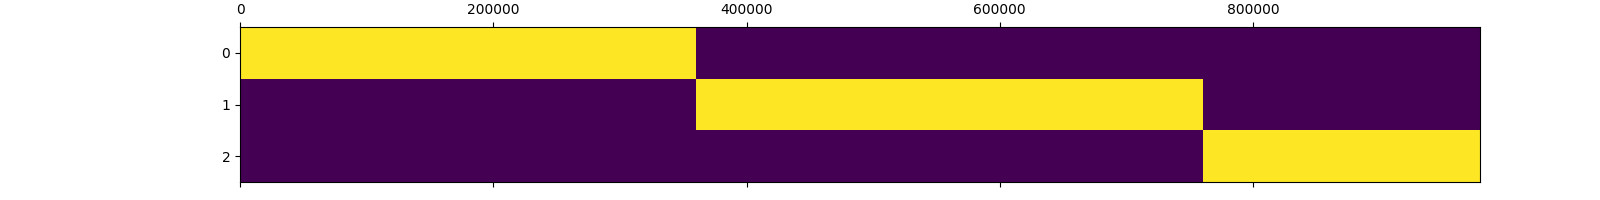

In [14]:
labels = np.zeros((len(plastic_data)+len(compost_data)+len(background_data),3))
labels[:len(plastic_data),0] = 1
labels[len(plastic_data):len(plastic_data)+len(compost_data),1] = 1
labels[len(plastic_data)+len(compost_data):,2] = 1

plt.matshow(labels.T, aspect='auto')

In [15]:
fulldata = np.concatenate((plastic_data, compost_data, background_data))
np.shape(fulldata)

(979210, 202)

In [16]:
scaler = preprocessing.MinMaxScaler()
fulldata_scaled = scaler.fit_transform(fulldata)

pd.DataFrame(fulldata_scaled).sample(500).T.plot.line()

In [17]:
X_train, X_test, y_train, y_test = train_test_split(fulldata_scaled, labels, test_size = 0.2,random_state = 1)

In [18]:
model = keras.models.Sequential([
    keras.layers.Input(202),
    keras.layers.Dense(96, activation="relu"),
    keras.layers.Dense(48, activation="relu"),
    keras.layers.Dense(3, activation="softmax")
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 96)                19488     
                                                                 
 dense_1 (Dense)             (None, 48)                4656      
                                                                 
 dense_2 (Dense)             (None, 3)                 147       
                                                                 
Total params: 24,291
Trainable params: 24,291
Non-trainable params: 0
_________________________________________________________________


In [19]:
import datetime

log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=0.2),
              metrics=["accuracy"])

training_history = model.fit(X_train, y_train, epochs=5, callbacks=[tensorboard_callback], batch_size=5000)

Epoch 1/5
157/157 [==============================] - 2s 7ms/step - loss: 0.4237 - accuracy: 0.8540
Epoch 2/5
157/157 [==============================] - 1s 6ms/step - loss: 0.1602 - accuracy: 0.9354
Epoch 3/5
157/157 [==============================] - 1s 6ms/step - loss: 0.1107 - accuracy: 0.9621
Epoch 4/5
157/157 [==============================] - 1s 7ms/step - loss: 0.1117 - accuracy: 0.9688
Epoch 5/5
157/157 [==============================] - 1s 7ms/step - loss: 0.0549 - accuracy: 0.9824


In [20]:
model.evaluate(X_test,y_test, callbacks=tensorboard_callback, batch_size=5000)

40/40 [==============================] - 0s 6ms/step - loss: 0.0514 - accuracy: 0.9832


[0.051379796117544174, 0.9832466840744019]

INFO:data_handling:	Data Source:   'D:\OneDriveFHNW\FHNW\EUT-P6bb-21HS-RS_M365 - General\captures/training\qd_kompost_sp10_mit_kunststoffen_1_2022-06-08_06-36-35\capture\REFLECTANCE_qd_kompost_sp10_mit_kunststoffen_1_2022-06-08_06-36-35.dat'
	# Rows:            859
	# Samples:         640
	# Bands:           224
	Interleave:        BIL
	Quantization:  16 bits
	Data format:    uint16


1100/1100 [==============================] - 2s 2ms/step
(549760,)


Text(0, -50, 'Plastic (Red), Compost (Orange), Background (Grey)')

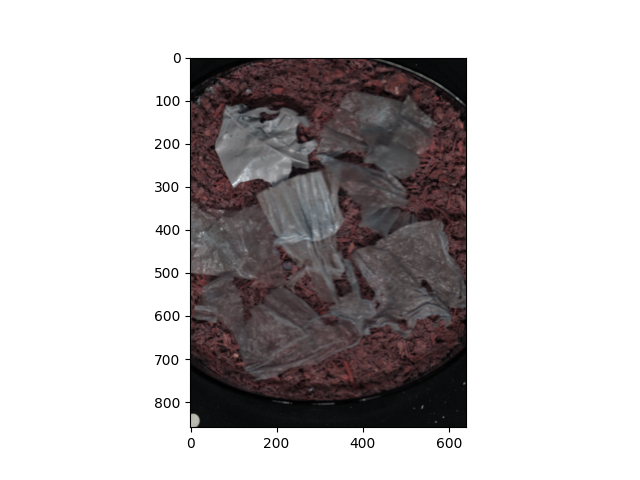

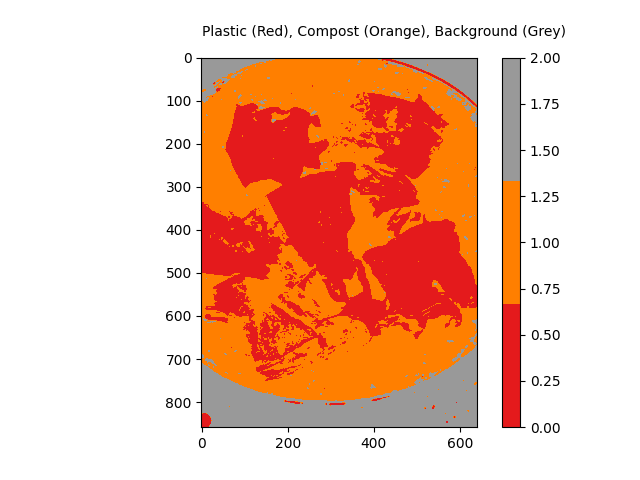

In [21]:
capture = get_hsi_capture("sp10_mit_kunststoffen_1", root_training)
data = load_hsi_data(capture)

im = spectral.imshow(data, RGB_BANDS)

[m,n,p] = np.shape(data)
data_2d = np.reshape(data, [m*n,p])
data_2d_clean = data_2d[:,8:210].copy()

data_2d_scaled = scaler.transform(data_2d_clean)

result = model.predict(data_2d_scaled, batch_size=500)

result_class = result.argmax(axis=1)
print(np.shape(result_class))
cmap = mpl.cm.get_cmap("Set1",3)
plt.figure()
plt.imshow(np.reshape(result_class, [m, n]), cmap=cmap)
plt.colorbar()
plt.text(0,-50,"Plastic (Red), Compost (Orange), Background (Grey)")